In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from scipy.optimize import curve_fit


In [5]:
def fit_func(x, a):
    # Curve fitting function
    return a * x   



In [22]:
#from autoclass import autorepr
#@autorepr
class runner():
    def __init__(self, name='' ,df=None):
        self.name=name # Runner name
        self.df=df     # Runner dataframe
        # self.number=number # runner number
        self.color=np.random.rand(3,)
        self.poly1ddiff=None
        self.poly1ddifftotal=None
        self.poly1dspeed=None
        self.mean_speed=None
        self.mean_speed_ms=None

        # Clean runner dataframe
        # Remove Unnamed Columns and rows with NaN
        self.df.drop(self.df.columns[self.df.columns.str.contains('Unnamed',case = False)],
                     axis = 1, inplace = True) #clean Unnamed columns
        self.df.dropna(inplace = True) #clean rows with Nan

   
    def dataframeprocess(self):
        self.df['Pace_in_seconds']=pd.to_timedelta(self.df['Avg Pace'].astype(str),
                                                   errors='coerce').apply(lambda x: x.total_seconds()/60)
        self.df['Diff_Elev']=self.df['Elev Gain']-self.df['Elev Loss']
        
        self.df['Slope']=self.df['Diff_Elev']/1000.0
        self.df['Race_number']= raceCounter(self.df['Laps'].to_numpy())
        self.df['Race_Avg_Pace_in_seconds']=raceAvgPaceInSeconds(self.df['Race_number'].to_numpy(),
                                                                 self.df['Pace_in_seconds'].to_numpy())
        self.df['Pace_Dev_in_seconds']=self.df['Pace_in_seconds']-self.df['Race_Avg_Pace_in_seconds']
        self.df['Pace_Dev_PerCent']=self.df['Pace_Dev_in_seconds']/self.df['Race_Avg_Pace_in_seconds']*100
        self.df['Total_Pace_Dev_PerCent']=self.df['Pace_Dev_in_seconds']/self.df['Pace_in_seconds'].mean()*100
        self.df['Speed_kmh']=3600/(self.df['Pace_in_seconds'])
        self.mean_speed=self.df['Speed_kmh'].to_numpy().mean()
        self.mean_speed_ms=self.mean_speed/3.6
        self.df['Speed_Dev_Ms']=self.df['Speed_kmh']/3.6-self.mean_speed_ms

    def setpoly1d(self):
        #d = np.polyfit(self.df['Pace_Dev_PerCent'].to_numpy().flatten(),
        #               self.df['Diff_Elev'].to_numpy().flatten(),1)
        #f=np.poly1d(d)
        d=curve_fit(fit_func,self.df['Pace_Dev_PerCent'].to_numpy().flatten(),
                       self.df['Diff_Elev'].to_numpy().flatten()) 
        f=np.poly1d([d[0][0],0.0])
        self.poly1ddiff=f
        self.df['Linear_Adjusted_Diff_Pace']=self.df.apply(lambda x: f(x['Pace_Dev_PerCent']),axis=1)


        #d = np.polyfit(self.df['Total_Pace_Dev_PerCent'].to_numpy().flatten(),
        #self.df['Diff_Elev'].to_numpy().flatten(),1)
        d = curve_fit(fit_func,self.df['Total_Pace_Dev_PerCent'].to_numpy().flatten(),
                      self.df['Diff_Elev'].to_numpy().flatten())
        
        f=np.poly1d([d[0][0],0.0])
        self.poly1ddifftotal=f
        self.df['Linear_Adjusted_Diff_Pace_Total']=self.df.apply(lambda x: f(x['Total_Pace_Dev_PerCent']),axis=1)


        ################
        #self.mean_speed=self.df['Speed_kmh'].to_numpy().mean()
        #self.mean_speed_ms=self.mean_speed/3.6
        speed_dev_percent=100*(self.df['Speed_kmh'].to_numpy()-self.mean_speed)/self.mean_speed
        
        self.df['Speed_Dev_Percent']=speed_dev_percent
        #d = np.polyfit(self.df['Diff_Elev'].to_numpy().flatten(), speed_dev_percent,1)
        d=curve_fit(fit_func,self.df['Diff_Elev'].to_numpy().flatten(), speed_dev_percent)
        f=np.poly1d([d[0][0],0.0])
        self.poly1dspeed=f
        self.df['Linear_Adjusted_Speed_Dev_Percent']=self.df.apply(lambda x: f(x['Diff_Elev']),axis=1)
        
        #d = np.polyfit(self.df['Slope'].to_numpy().flatten(),self.df['Speed_Dev_Ms'],1)
        d = curve_fit(fit_func,self.df['Slope'].to_numpy().flatten(),self.df['Speed_Dev_Ms'])
        f=np.poly1d([d[0][0],0.0])
        
        self.poly1dspeedms=f
        self.df['Linear_Adjusted_Speed_Dev_Ms']=self.df.apply(lambda x: f(x['Slope']),axis=1)
        

    def poly1dplots(self):
        if self.poly1ddiff is None:
            self.setpoly1d()

        #color_r=self.df['Race_number'].to_numpy()/np.linalg.norm(self.df['Race_number'].to_numpy())*self.color[0]
        #color_g=self.df['Race_number'].to_numpy()/np.linalg.norm(self.df['Race_number'].to_numpy())*self.color[1]
        #color_b=self.df['Race_number'].to_numpy()/np.linalg.norm(self.df['Race_number'].to_numpy())*self.color[2]
        #colors=(color_r,color_g,color_b)
        z=self.df['Race_number'].to_numpy()
        scaled_z = z  / z.max()
        colors = plt.cm.coolwarm(scaled_z)

        fig,(ax0,ax2,ax1,ax3) = plt.subplots(1,4)
        ax0.scatter(self.df['Pace_Dev_PerCent'].to_numpy(),
                    self.df['Diff_Elev'].to_numpy(),marker='o',color=colors)
        self.df.plot(x='Pace_Dev_PerCent',y='Linear_Adjusted_Diff_Pace',marker='',linestyle='-',color='green',ax=ax0)
        ax0.set_xlim(self.df['Pace_Dev_PerCent'].min(),self.df['Pace_Dev_PerCent'].max())
        ax0.set(xlabel='Pace deviation %', ylabel='Diff Elev in m',title=self.name+''+str(self.poly1ddiff))
        ax0.grid()

        ax2.scatter(self.df['Total_Pace_Dev_PerCent'].to_numpy(),
                    self.df['Diff_Elev'].to_numpy(),marker='o',color=colors)
        self.df.plot(x='Total_Pace_Dev_PerCent',y='Linear_Adjusted_Diff_Pace_Total',marker='',linestyle='-',color='green',ax=ax2)
        ax2.set_xlim(self.df['Total_Pace_Dev_PerCent'].min(),self.df['Total_Pace_Dev_PerCent'].max())
        ax2.set(xlabel='Total Pace deviation %', ylabel='Diff Elev in m',title=self.name+''+str(self.poly1ddifftotal))
        ax2.grid()


        ax1.scatter(self.df['Diff_Elev'].to_numpy(),self.df['Speed_Dev_Percent'].to_numpy(),marker='o',color=colors)
        self.df.plot(x='Diff_Elev',y='Linear_Adjusted_Speed_Dev_Percent',marker='',linestyle='-',color='green',ax=ax1)
        #ax1.set_xlim(self.df['Diff_Elev'].min(),self.df['Diff_Elev'].max())
        ax1.set_xlim(-100,100)
        ax1.set(xlabel='Diff Elev in m', ylabel='Speed deviation in %',title=self.name+''+str(self.poly1dspeed))
        ax1.grid()
        
        ax3.scatter(self.df['Slope'].to_numpy(),self.df['Speed_Dev_Ms'].to_numpy(),marker='o',color=colors)
        self.df.plot(x='Slope',y='Linear_Adjusted_Speed_Dev_Ms',marker='',linestyle='-',color='green',ax=ax3)
        ax3.set_xlim(self.df['Slope'].min(),self.df['Slope'].max())
        #ax3.set_xlim(-100,100)
        ax3.set(xlabel='Slope', ylabel='Speed deviation in m/s',title=self.name+''+str(self.poly1dspeedms))
        ax3.grid()
        plt.show()

    def poly1dplot3(self):
        if self.poly1ddiff is None:
            self.setpoly1d()

            
        z=self.df['Race_number'].to_numpy()
        scaled_z = z  / z.max()
        colors = plt.cm.coolwarm(scaled_z)

        fig,ax1 = plt.subplots(1,1)
        


        ax1.scatter(self.df['Diff_Elev'].to_numpy(),self.df['Speed_Dev_Percent'].to_numpy(),marker='o',color=colors)
        self.df.plot(x='Diff_Elev',y='Linear_Adjusted_Speed_Dev_Percent',marker='',linestyle='-',label=str(self.poly1dspeed),color='green',ax=ax1)
        #ax1.set_xlim(self.df['Diff_Elev'].min(),self.df['Diff_Elev'].max())
        ax1.set_xlim(-100,100)
        ax1.set(xlabel='Difference in elevation in meters', ylabel='Speed deviation in %')
        ax1.grid()
        plt.show()
   


    def info(self):
        print('--------------------------------------------------------------')
        print('Runner name is ', self.name) #, '[number=', self.number,']')
        print('Total distance= {} Km'.format(len(self.df['Laps'])))
        print('Number of races = {:.0f}'.format(self.df['Race_number'].to_numpy().max()))
        print('Better pace= {} in m:s'.format(self.df['Avg Pace'].to_numpy().min()))
        print('Worst pace= {}  in m:s'.format(self.df['Avg Pace'].to_numpy().max()))
        print('Best speed= {:.2f}  in km/h'.format(self.df['Speed_kmh'].to_numpy().max()))
        print('Worst speed= {:.2f} in km/h'.format(self.df['Speed_kmh'].to_numpy().min()))
        print('Average speed= {:.2f} in km/h'.format(self.mean_speed))
        print('Average speed= {:.2f} in m/s'.format(self.mean_speed_ms))      
        print('Total time= {} in h:m:s'.format(datetime.timedelta(seconds = self.df['Pace_in_seconds'].sum())))
        
        print('--------------------------------------------------------------')


    #def __str__(self):
    #    return ''' {}
    #    Runner: name is {},
    #    number is {},
    #    color is {},
    #    total distance is {}'''.format(self.__class__.__name__,self.name,
    #                          self.number,self.color,self.totaldistance)

    #def __repr__(self):
    #    return ''' <{} instance at {}>
    #    Runner: name is {},
    #    dataframe is {},
    #    number is {},
    #    color is {},
    #    total distance is {}'''.format(self.__class__.__name__,
    #                          id(self),self.name,
    #                          self.df.head(n=1),self.number
    #                          self.color,self.totaldistance)


#Auxiliar functions
def raceCounter(Laps=None):
    aux,=np.where(Laps==1) #first lap of each race
    #print(len(aux[:-1]))
    #print(len(Laps))
    #print(Laps)
    rtrnarray=np.zeros(len(Laps))
    counter=1

    if len(aux[:-1])>1:
        for index,item in enumerate(aux[:-1]):
            #print(index,'',item)
            #print(aux[0][index],'',aux[0][index+1]+1)
            rtrnarray[aux[index]:aux[index+1]]=counter
            counter+=1

        rtrnarray[aux[index+1]:len(Laps) ]=counter #last race
    else:
        #Required for the case where only one race is done (e.g. Luis)
        rtrnarray[:]=counter #last race
    return rtrnarray

def raceAvgPaceInSeconds(Race_number=None, Pace_in_seconds=None):
    #print(np.diff(Race))
    # index where each Race begin
    aux,=np.where(np.diff(Race_number)==1)
    aux=np.insert(np.copy(aux)+1,0,0)
    #print(aux)
    rtrnarray=np.zeros(len(Race_number))
    counter=1

    if len(aux)>1:
        for index,item in enumerate(aux[:-1]):
            #print(index,'',item)
            #print(aux[0][index],'',aux[0][index+1]+1)
            rtrnarray[aux[index]:aux[index+1]]=Pace_in_seconds[aux[index]:aux[index+1]].mean()

        rtrnarray[aux[index+1]:]=Pace_in_seconds[aux[index+1]:].mean() #last race
    else:
        #Required for the case where only one race is done (e.g. Luis)
        rtrnarray[:]=Pace_in_seconds.mean() #last race

    return rtrnarray

#from runnerclass import * # As contas estão aqui



In [23]:
np.random.seed(2875620985) 
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 75 # 200 e.g. is really fine, but slower



#Data Source
df = pd.read_excel('Splits13raw.xlsx',sheet_name=None)

## Processing  the dataframes for each runner

In [24]:
Runner=[]

for key in df.keys():
    Runner.append(runner(name=key,df=df[key]))



In [25]:
# As colunas que faltam
for runner in Runner:
    runner.dataframeprocess()  
    
print(Runner[1].df)

     Laps  Avg Pace  Elev Gain  Elev Loss  Pace_in_seconds  Diff_Elev  Slope  \
0       1  04:50:00          8         32            290.0        -24 -0.024   
1       2  04:30:00          7          8            270.0         -1 -0.001   
2       3  04:31:00          4          4            271.0          0  0.000   
3       4  04:32:00         27          9            272.0         18  0.018   
4       5  04:12:00          4         31            252.0        -27 -0.027   
..    ...       ...        ...        ...              ...        ...    ...   
147     8  04:56:00         32          6            296.0         26  0.026   
148     9  04:52:00          8         20            292.0        -12 -0.012   
149    10  04:31:00         22         10            271.0         12  0.012   
150    11  05:00:00         17         31            300.0        -14 -0.014   
151    12  04:53:00          7         14            293.0         -7 -0.007   

     Race_number  Race_Avg_Pace_in_seco

# Info & linear regressions

In [26]:
for runner in Runner:
    runner.info()

--------------------------------------------------------------
Runner name is  Hugo
Total distance= 79 Km
Number of races = 6
Better pace= 03:58:00 in m:s
Worst pace= 09:11:00  in m:s
Best speed= 15.13  in km/h
Worst speed= 6.53 in km/h
Average speed= 11.10 in km/h
Average speed= 3.08 in m/s
Total time= 7:22:41 in h:m:s
--------------------------------------------------------------
--------------------------------------------------------------
Runner name is  Ricardo
Total distance= 152 Km
Number of races = 11
Better pace= 03:51:00 in m:s
Worst pace= 06:31:00  in m:s
Best speed= 15.58  in km/h
Worst speed= 9.21 in km/h
Average speed= 12.94 in km/h
Average speed= 3.60 in m/s
Total time= 11:50:23 in h:m:s
--------------------------------------------------------------
--------------------------------------------------------------
Runner name is  Eduardo
Total distance= 158 Km
Number of races = 8
Better pace= 03:28:00 in m:s
Worst pace= 05:23:00  in m:s
Best speed= 17.31  in km/h
Worst spe

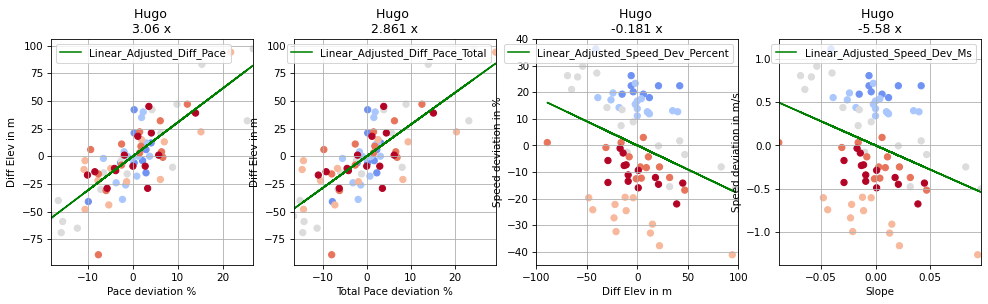

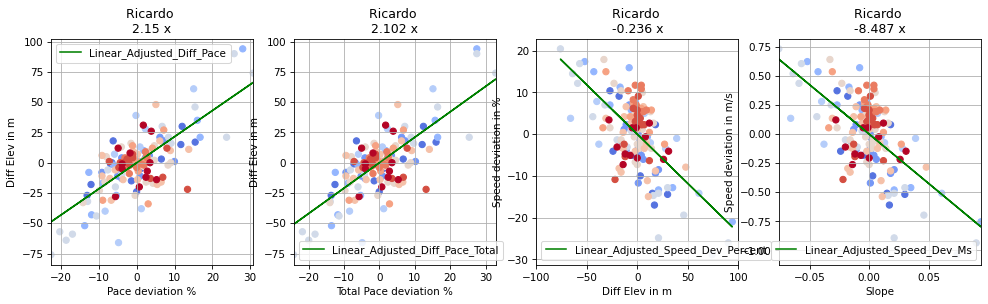

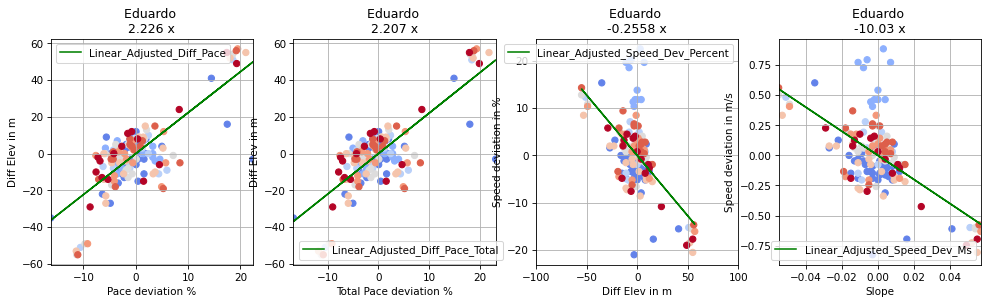

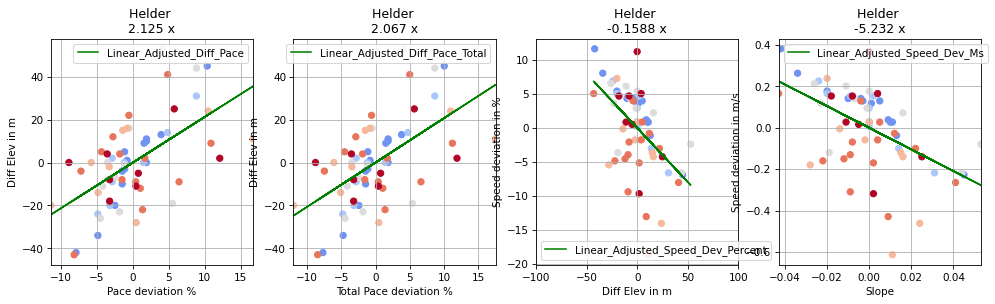

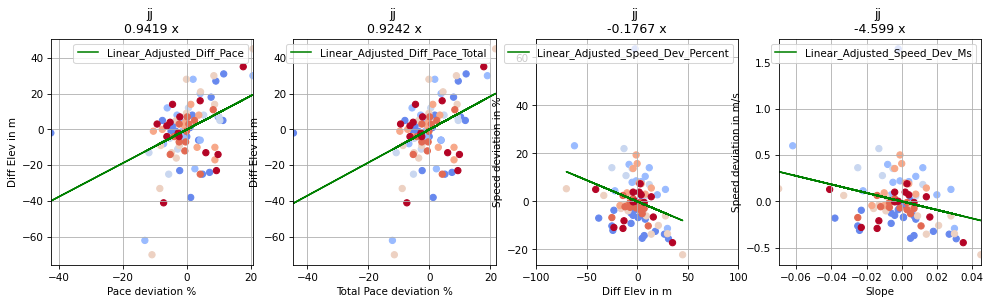

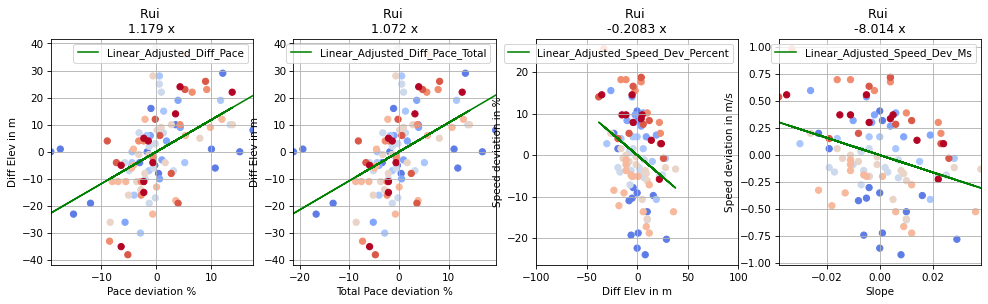

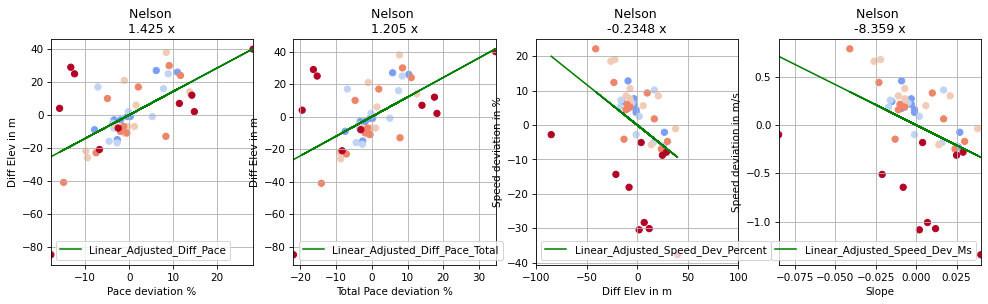

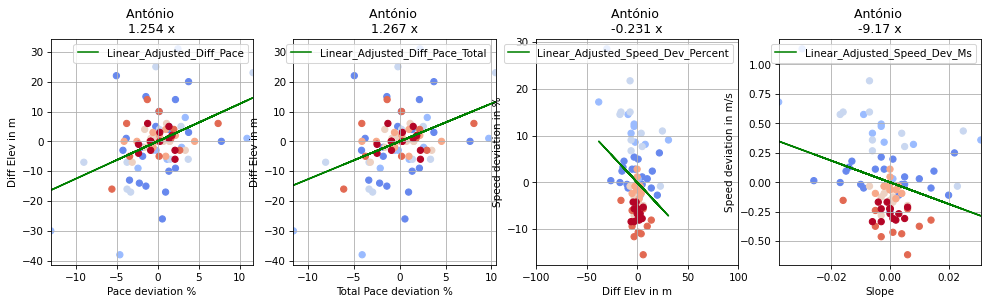

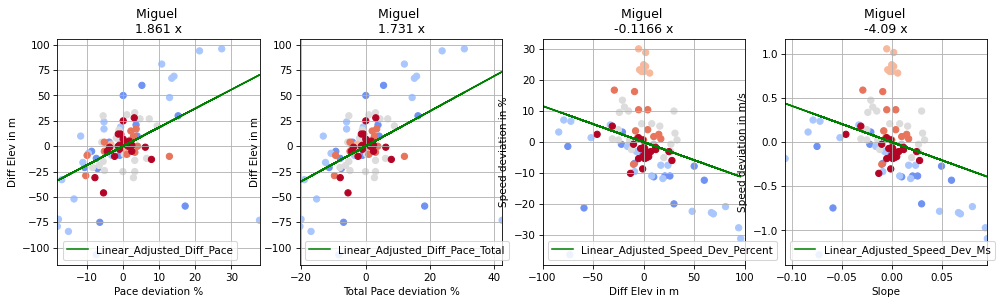

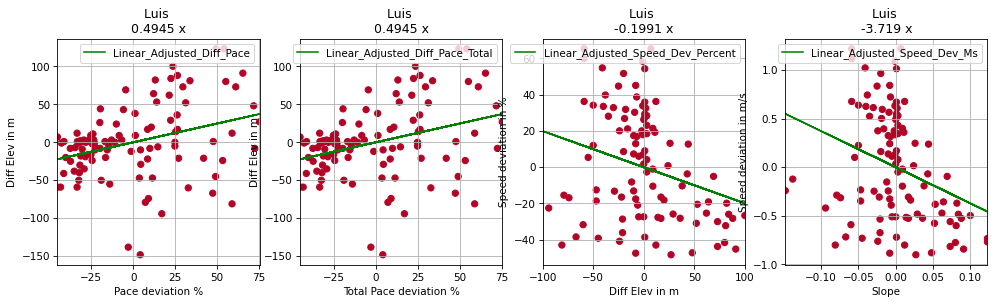

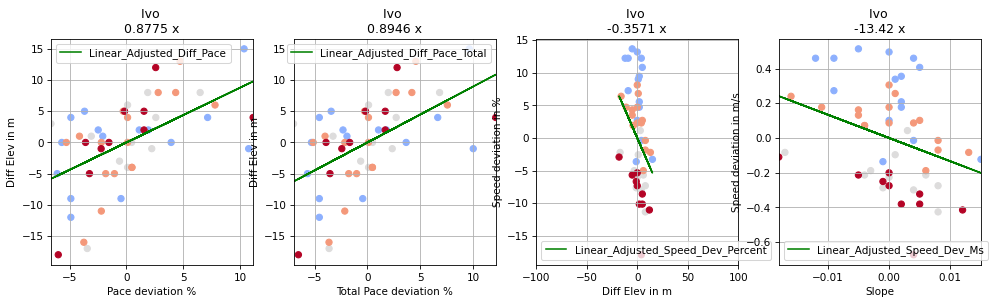

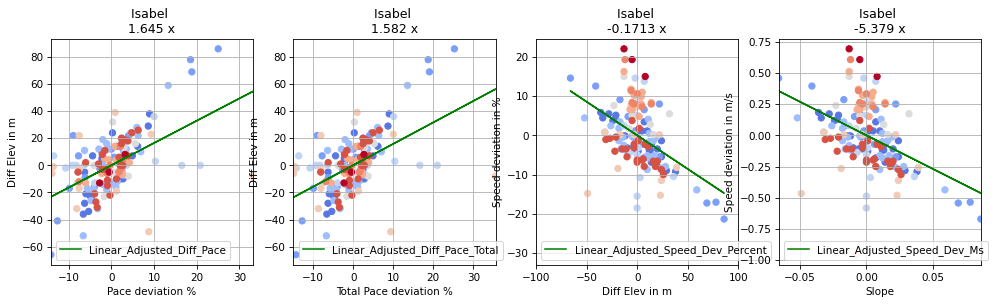

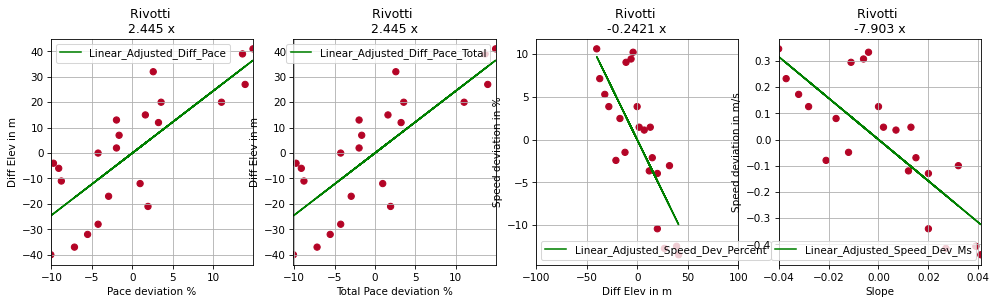

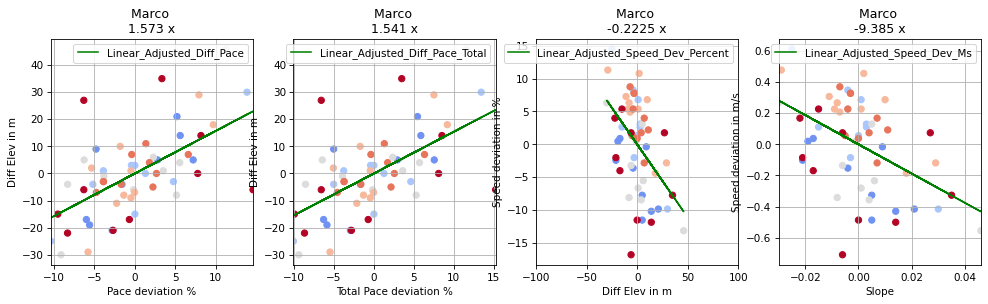

In [27]:
for runner in Runner:
    runner.poly1dplots()

# Next step: simulations #

In [28]:
print(Runner[1].name)

Ricardo


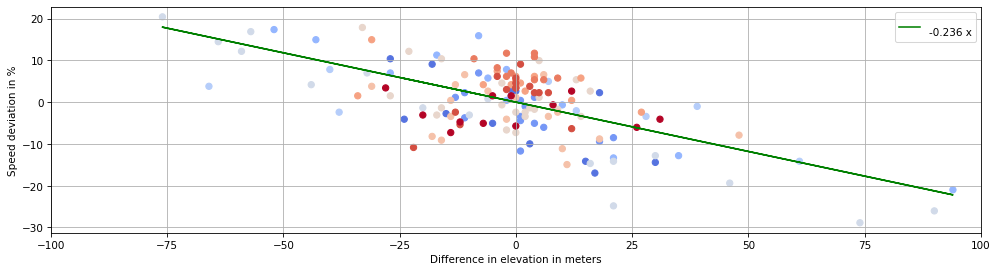

In [29]:
Runner[1].poly1dplot3()